# Data Quality Test

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import linregress
from multiprocessing import Pool

import snpy
from snpy.CSPtemp import st_template

%config InlineBackend.figure_format = 'retina'
plt.rcParams["font.family"] = "Gentium"
plt.rcParams['mathtext.fontset'] = "cm"

print(f'SNooPy version: v{snpy.__version__}')

SNOOPY_MODEL = 'max_model'
DATA_DIR = 'csp_data'
PROCESSES = 8

SNooPy version: v2.6.0


In [2]:
def get_parameter(sn, parameter, include_sys=False):
    """Obtains the value of the given parameter and
    the total (systematics + statistical) uncertainty
    of a fitted SN.
    
    Parameters
    ==========
    sn: SNooPy object
        SN in a SNooPy object.
    parameter: str
        Parameter to extract.
    include_sys: bool
        If `True`, systematic uncertainties are 
        included.
        
    Returns
    =======
    value: float
        Value of the parameter.
    err: float
        Total uncertainty in the parameter. 
    """
    
    value = sn.parameters[parameter]
    stats_err = sn.errors[parameter]
    if include_sys:
        sys_err = sn.systematics()[parameter]
    else:
        sys_err = 0.0
    err = np.sqrt(stats_err**2 + sys_err**2)
    
    return value, err

def cadence_mask(step, length):
    """Extracts a mask of the given length
    with True every `step` amount of items.
    
    Parameters
    ----------
    step: int
        Step to use to take every x amount of items.
    length: int
        Length of the mask.
        
    Returns
    -------
    mask: bool list
        List of booleans.
    """
    
    indeces = list(range(length))
    mask = []
    step_indeces = indeces[::step]
    
    for index in indeces:
        if index in step_indeces:
            mask.append(True)
        else:
            mask.append(False)
    mask = np.array(mask)       
    
    return mask

def update_cadence(sn, steps, bands=None):
    """Updates the light-curves cadence with the 
    given steps and fits the SN.
    
    Parameters
    ----------
    sn: SNooPy object
        SN in SNooPy format.
    steps: list-like
        Steps to use to take every x amount of items.
    bands: list, default `None`
        Bands to use for the SNooPy fits. If `None`,
        use all bands.
        
    Returns
    -------
    cadence_df: DataFrame
        Pandas dataframe with cadences and other 
        SN parameters.
    """
    
    if bands is None:
        bands = sn.allbands()
        
    # initial fit
    sn.choose_model(SNOOPY_MODEL)
    sn.fit(bands)
    
    cadences_list = []
    cadences = {band:None for band in sn.allbands()}
    for band in sn.allbands():
        lc_len = len(sn.data[band].mask)
        lc_times = sn.data[band].MJD
        cadences[band] = np.mean(np.diff(lc_times))
    Tmax, Tmax_err = get_parameter(sn, 'Tmax', 
                                   include_sys=False)
    st, st_err = get_parameter(sn, 'st', 
                                include_sys=False)
    cadences.update({'Tmax':Tmax, 'Tmax_err':Tmax_err,
                     'st':st, 'st_err':st_err,
                    'name':sn.name})
    cadences_list.append(cadences)

    # fits for multiple cadences
        
    for step in steps:
        cadences = {band:None for band in bands}
        for band in bands:
            lc_len = len(sn.data[band].mask)
            mask = cadence_mask(step, lc_len)
            sn.data[band].__dict__['mask'] = mask
            lc_times = sn.data[band].MJD[mask]
            cadences[band] = np.mean(np.diff(lc_times))

        sn.choose_model(SNOOPY_MODEL)
        sn.fit(bands)
        Tmax, Tmax_err = get_parameter(sn, 'Tmax', 
                                   include_sys=False)
        st, st_err = get_parameter(sn, 'st', 
                                    include_sys=False)
        cadences.update({'Tmax':Tmax, 'Tmax_err':Tmax_err,
                         'st':st, 'st_err':st_err, 
                        'name':sn.name})
        cadences_list.append(cadences)
        
    # add NaN to bands with no information
    bands = ['g', 'r', 'i', 'u', 'B', 'V', 'J', 'H', 'Y']
    for cadence in cadences_list:
        for band in bands:
            if band not in cadence.keys():
                cadence.update({band:np.nan})
      
    cadence_df = pd.DataFrame(cadences_list)
    
    return cadence_df

def update_snr(sn, multi, bands=None):
    """Updates the light-curves S/N with the 
    given multiplicative values and fits the SN.
    
    Parameters
    ----------
    sn: SNooPy object
        SN in SNooPy format.
    multi: list-like
        Multiplicative values such that x*sigma is used
        as errors in the observations.
    bands: list, default `None`
        Bands to use for the SNooPy fits. If `None`,
        use all bands.
        
    Returns
    -------
    snr_df: DataFrame
        Pandas dataframe with snr and other 
        SN parameters.
    """
    if bands is None:
        bands = sn.allbands()
    
    # initial fit
    sn.choose_model(SNOOPY_MODEL)
    sn.fit(bands)
    
    snr_list = []
    snr_dict = {band:None for band in sn.allbands()}
    for band in sn.allbands():
        snr = sn.data[band].flux/sn.data[band].e_flux
        snr_dict[band] = np.mean(snr)
    Tmax, Tmax_err = get_parameter(sn, 'Tmax', 
                                   include_sys=False)
    st, st_err = get_parameter(sn, 'st', 
                                include_sys=False)
    snr_dict.update({'Tmax':Tmax, 'Tmax_err':Tmax_err,
                     'st':st, 'st_err':st_err,
                    'name':sn.name})
    snr_list.append(snr_dict)

    # fits for multiple cadences
    for mult in multi:
        snr_dict = {band:None for band in bands}
        sn_file = os.path.join(DATA_DIR, f'{sn.name}_snpy.txt')
        sn = snpy.import_lc(sn_file)
        for band in bands:
            # unchanged observations
#             sn.data[band].e_mag = mult*sn.data[band].e_mag
#             sn.data[band].e_flux = mult*sn.data[band].e_flux
#             sn.data[band]._eflux = mult*sn.data[band]._eflux
            
            # randomise observations within uncertainties
            sn.data[band].e_flux = mult*sn.data[band].e_flux
            sn.data[band]._eflux = mult*sn.data[band]._eflux

            zp = sn.data[band].mag + 2.5*np.log10(sn.data[band].flux)
            new_flux = np.random.normal(sn.data[band].flux, sn.data[band].e_flux)
            sn.data[band].flux = new_flux

            new_mag = -2.5*np.log10(new_flux) + zp
            new_mag_err = np.abs( 2.5*sn.data[band].e_flux/(new_flux*np.log(10)) )
            sn.data[band].mag = new_mag
            sn.data[band].magnitude = new_mag
            sn.data[band].e_mag = new_mag_err
            
            snr = sn.data[band].flux/sn.data[band].e_flux
            snr_dict[band] = np.median(snr)

        sn.choose_model(SNOOPY_MODEL)
        sn.fit(bands)
        Tmax, Tmax_err = get_parameter(sn, 'Tmax', 
                                   include_sys=False)
        st, st_err = get_parameter(sn, 'st', 
                                    include_sys=False)
        snr_dict.update({'Tmax':Tmax, 'Tmax_err':Tmax_err,
                         'st':st, 'st_err':st_err, 
                        'name':sn.name})
        snr_list.append(snr_dict)
        
    # add NaN to bands with no information
    bands = ['g', 'r', 'i', 'u', 'B', 'V', 'J', 'H', 'Y']
    for snr in snr_list:
        for band in bands:
            if band not in snr.keys():
                snr.update({band:np.nan})
      
    snr_df = pd.DataFrame(snr_list)
    
    return snr_df

In [3]:
def pool_fit(sn_file):
    '''Fits a SN with SNooPy using multiple cadences and 
    returns the saved results.
    
    Parameters
    ==========
    sn_file: str
        SN file in SNooPy format.

    Returns
    =======
    The SN's saved results in a DataFrame, if successful.
    '''
    
    sn = snpy.import_lc(sn_file)
        
    if 'K' in sn.allbands():
        sn.data.pop('K')
        
    try:
        cadence_df = update_cadence(sn, range(2, 11), ['g', 'r'])
        return cadence_df
    except Exception as message:
        print(f'Unable to fit {sn.name}: {message}')
        
def pool_fit2(sn_file):
    '''Fits a SN with SNooPy using multiple S/N and 
    returns the saved results.
    
    Parameters
    ==========
    sn_file: str
        SN file in SNooPy format.

    Returns
    =======
    The SN's saved results in a DataFrame, if successful.
    '''
    
    sn = snpy.import_lc(sn_file)
        
    if 'K' in sn.allbands():
        sn.data.pop('K')
        
    try:
        snr_df = update_snr(sn, [2, 3, 5, 6, 7], ['g', 'r'])
        return snr_df
    except Exception as message:
        print(f'Unable to fit {sn.name}: {message}')

## Cadences

In [4]:
with open('reference_files.txt') as ref_file:
    sn_files = ref_file.read().splitlines()

%time cadences_list = Pool(PROCESSES).map(pool_fit, (sn_file for sn_file in sn_files))

/home/tomas/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/tomas/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Unable to fit SN2005kc: All weights for filter g are zero. The fitter is in a part of parameter space where the model is not valid or there is no useful data.
Unable to fit ASAS14jz: All weights for filter g are zero. The fitter is in a part of parameter space where the model is not valid or there is no useful data.
Unable to fit SN2006hx: All weights for filter g are zero. The fitter is in a part of parameter space where the model is not valid or there is no useful data.
Unable to fit SN2006kf: All weights for filter g are zero. The fitter is in a part of parameter space where the model is not valid or there is no useful data.
Unable to fit SN2009ab: Error:  Covariance Matrix is singular.  Either two or more parameters are degenerate or the model has become insensitive to one or more parameters.
Unable to fit SN2005hc: All weights for filter g are zero. The fitter is in a part of parameter space where the model is not valid or there is no useful data.
Unable to fit SN2007ca: Error:  C

In [5]:
cad_stats_df = pd.concat(cadences_list, ignore_index=True)
cad_stats_df.to_csv('cadence_stats.csv', index=False)

___

In [6]:
def extract_gradient(st=1.0, bands=None):
    """Extracts the gradient from the SNooPy templates.
    
    Parameters
    ----------
    st: float
        SN stretch.
    bands: list-like, default `None`
        Bands to fit.
        
    returns
    -------
    lc_dict: dictionary
        Dictionary with the template light curves and 
        gradients.
    """
    
    t = st_template()
    t.st = st
    epochs = np.arange(-10, 80)
    if bands is None:
        bands = ['g', 'r', 'i', 'u', 'B', 'V', 
                 'J', 'H', 'Y']
    lc_dict = {band:None for band in bands}

    for band in bands:
        mag, mag_err, mask = t.eval(band, epochs, gen=2)
        lc_dict[band] = {'mag':mag[mask], 
                         'mag_err':mag_err[mask],
                         'time':epochs[mask]}
        gradient = []
        for i in range(len(epochs[mask])-1):
            # slope, intercept, r_value, p_value, std_err
            slope, _, _, _, _ = linregress(epochs[mask][i:i+2], 
                                           mag[mask][i:i+2])
            gradient.append(slope)
        lc_dict[band].update({'slope':np.array(gradient)})
        
    return lc_dict

In [7]:
cad_stats_df = pd.read_csv('cadence_stats.csv')
sn_names = cad_stats_df.name.unique()

res_dict = {'Tmax_diff':[], 'Tmax_err':[], 'g':[], 'r':[],
            'same_cad':[], 'diff_cad':[]}
lc_snake = {band:{'err':[], 'time':[]} for band in ['J', 'H']}
for sn_name in sn_names:
    sn_df = cad_stats_df[cad_stats_df.name==sn_name]
    ref_df = sn_df.iloc[0]
    
    # using cadences in g-band as reference
    for i in range(1, len(sn_df)):
        sim_df = sn_df.iloc[i]
        if (sim_df.g>=0) and (sim_df.g<=10):
            Tmax_diff = sim_df.Tmax - ref_df.Tmax
            res_dict['Tmax_diff'].append(Tmax_diff)
            res_dict['Tmax_err'].append(sim_df.Tmax_err)
            res_dict['g'].append(sim_df.g)
            res_dict['r'].append(sim_df.r)
            if i==1:
                res_dict['same_cad'].append(True)
                res_dict['diff_cad'].append(False)
            else:
                res_dict['same_cad'].append(False)
                res_dict['diff_cad'].append(True)
            
            lc_dict = extract_gradient(ref_df.st)
            for band in ['J', 'H']:
                lc = lc_dict[band]
                time = lc['time'][:-1]+0.5
                grad = lc['slope']
                err = Tmax_diff * grad
                lc_snake[band]['err'].append(err)
                lc_snake[band]['time'].append(time)
            
res_df = pd.DataFrame(res_dict)

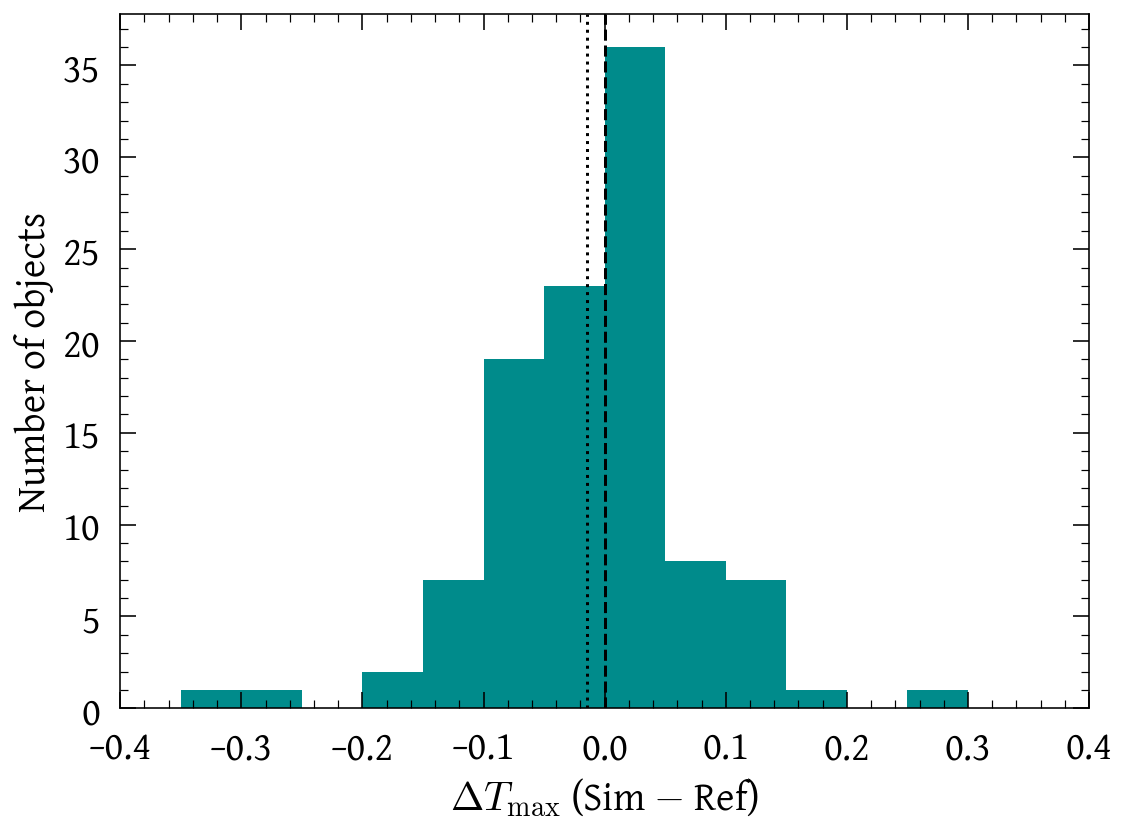

-0.014583532046948268


In [8]:
fig, ax = plt.subplots(figsize=(8, 6))

bins = np.arange(-0.45, 0.5, 0.05)
ax.hist(res_df.Tmax_diff, bins, color='darkcyan')
ax.axvline(0, ls='--', c='k')
ax.axvline(res_df.Tmax_diff.mean(), ls='dotted', c='k')

ax.set_xlabel(r'$\Delta T_{\rm max}$ (Sim $-$ Ref)', fontsize=20)
ax.set_ylabel('Number of objects', fontsize=20)
ax.tick_params(labelsize=20)
ax.set_xlim(-0.4, 0.4)

fig.tight_layout()
plt.savefig('paper_plots/delta_Tmax_cadence.pdf')
plt.show()

print(res_df.Tmax_diff.mean())

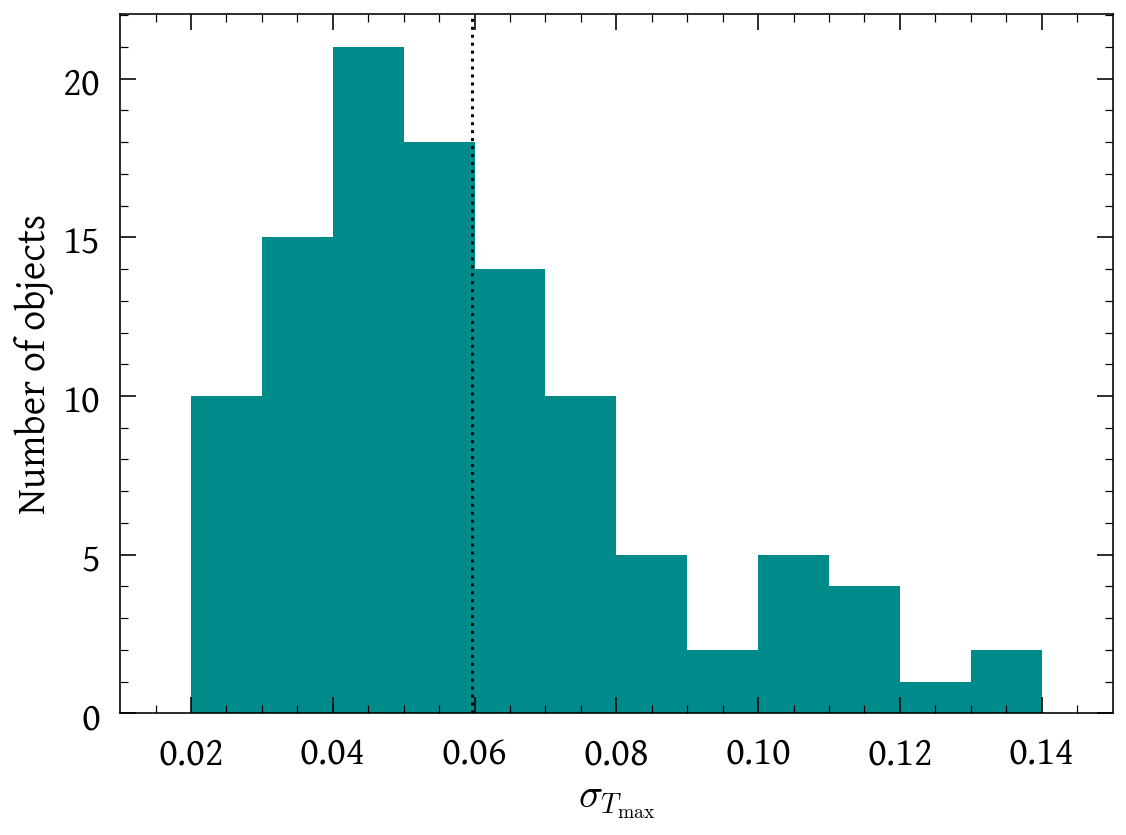

0.059594389160131586


In [10]:
fig, ax = plt.subplots(figsize=(8, 6))

bins = np.arange(0, 0.55, 0.01)
ax.hist(res_df.Tmax_err, bins, color='darkcyan')
ax.axvline(res_df.Tmax_err.mean(), ls='dotted', c='k')

ax.set_xlabel(r'$\sigma_{T_{\rm max}}$', fontsize=20)
ax.set_ylabel('Number of objects', fontsize=20)
ax.tick_params(labelsize=20)
ax.set_xlim(0.01, 0.15)

fig.tight_layout()
plt.savefig('paper_plots/sigma_Tmax_cadence.pdf')
plt.show()
print(res_df.Tmax_err.mean())

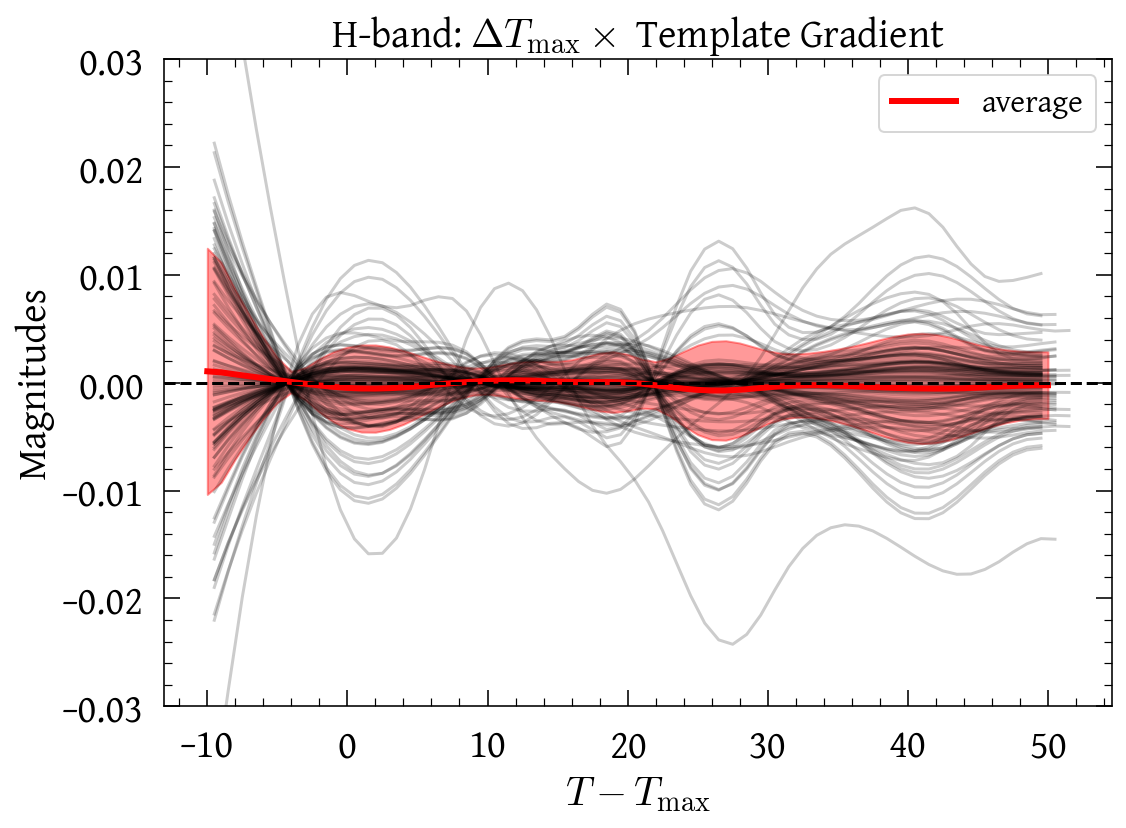

In [35]:
band = 'H'

avg_err = []
epochs = np.arange(-10, 51)

fig, ax = plt.subplots(figsize=(8, 6))
for err, time in zip(lc_snake[band]['err'], 
                     lc_snake[band]['time']):
    
    interp_err = np.interp(epochs, time, err)
    
    # remove weird outliers
    if np.all(np.abs(interp_err)<0.05):
        ax.plot(time, err, 'k', alpha=0.2)
        avg_err.append(interp_err)
    
std_err = np.std(avg_err, axis=0)
avg_err = np.average(avg_err, axis=0)
ax.plot(epochs, avg_err, 'r', label='average', lw=3)
ax.fill_between(epochs, avg_err+std_err, avg_err-std_err, color='r', alpha=0.4)
ax.axhline(0, ls='--', c='k')

ax.set_xlabel(r'$T - T_{\rm max}$', fontsize=20)
ax.set_ylabel('Magnitudes', fontsize=20)
ax.set_title(f'{band}-band: '+r'$\Delta T_{\rm max} \times$ Template Gradient', fontsize=20)
ax.tick_params(labelsize=20)
ax.set_ylim(-0.03, 0.03)
ax.legend(loc=1, fontsize=16)
fig.tight_layout()
plt.savefig(f'paper_plots/Tmax_gradient_cadence_{band}.pdf')
plt.show()

In [13]:
def bin_values(bins, x_values, y_values, y_err):
    """Values are binned using the given bins.
    
    Parameters
    ==========
    bins: array
        array of bins
    x_values: array
        array of x-axis values
    y_values: array
        array of y-axis values
    y_err: array
        array of y-axis errors
        
    Returns
    =======
    delta_bins, std_bins, err_bins: arrays
        Arrays of
    """
    
    digitized = np.digitize(x_values, bins)
    delta_bins, std_bins, err_bins = [], [], []
    
    for i in range(0, len(bins)):
        if len(y_values[digitized == i])>0:
            y = y_values[digitized == i]
            w = 1/y_err[digitized == i]**2
            
            wmean = np.nanmean(y)
            werr = np.sqrt(np.nan)
            wstd = np.nanstd(y)
            
            delta_bins.append(wmean)
            std_bins.append(wstd)
            err_bins.append(werr)
        else:
            delta_bins.append(np.nan)
            std_bins.append(np.nan)
            err_bins.append(np.nan)

    delta_bins = np.array(delta_bins) 
    std_bins = np.array(std_bins)
    err_bins = np.array(err_bins)
    
    return delta_bins, std_bins, err_bins

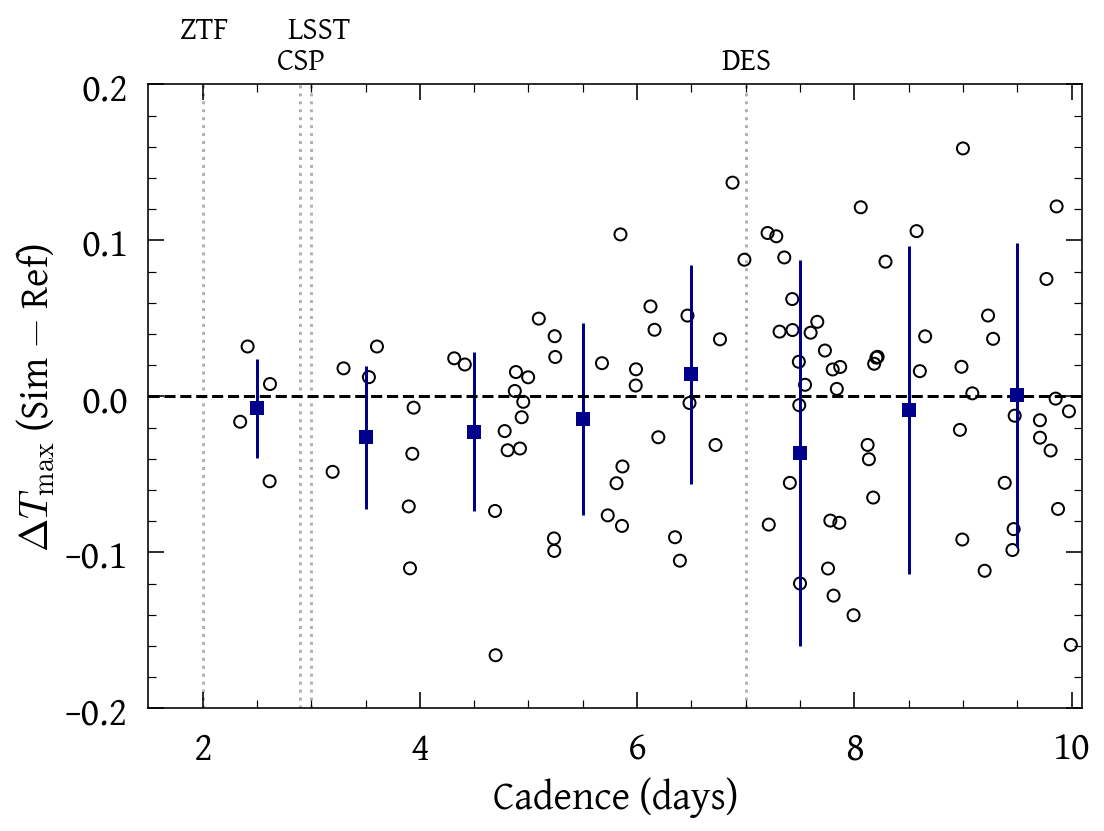

In [33]:
cadence_dict = {'CSP':2.9,
                'ZTF':2,
                'DES':7, 
                'LSST':3}
text_shift = []

bins = np.arange(0, 11, 1)
bins_results =  bin_values(bins, res_df.g.values, 
                           res_df.Tmax_diff.values, 
                           np.ones_like(res_df.g.values))
delta_bins, std_bins, err_bins = bins_results


fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(res_df.g, res_df.Tmax_diff, marker='o' , ec='k', facecolors='none')
same_cad_df = res_df[res_df.same_cad.values]

# same cadence
#ax.scatter(same_cad_df.g, same_cad_df.Tmax_diff, marker='o', c='m', alpha=0.4)

# bins
ax.errorbar(bins-0.5, delta_bins, yerr=std_bins, fmt='s', c='darkblue')

ax.axhline(0, ls='--', c='k')

for survey, cad in cadence_dict.items():
    if survey in ['ZTF', 'LSST']:
        yoffset = 0.23
    else:
        yoffset = 0.21
    ax.axvline(cad, ls='dotted', c='k', alpha=0.3)
    ax.text(cad-0.22, yoffset, survey, fontsize=16)

ax.set_xlabel(r'Cadence (days)', fontsize=20)
ax.set_ylabel(r'$\Delta T_{\rm max}$ (Sim $-$ Ref)', fontsize=20)
ax.tick_params(labelsize=20)
ax.set_xlim(1.5, 10.1)
ax.set_ylim(-0.2, 0.2)

fig.tight_layout()
plt.savefig(f'paper_plots/delta_Tmax_vs_cadence.pdf')
plt.show()

___

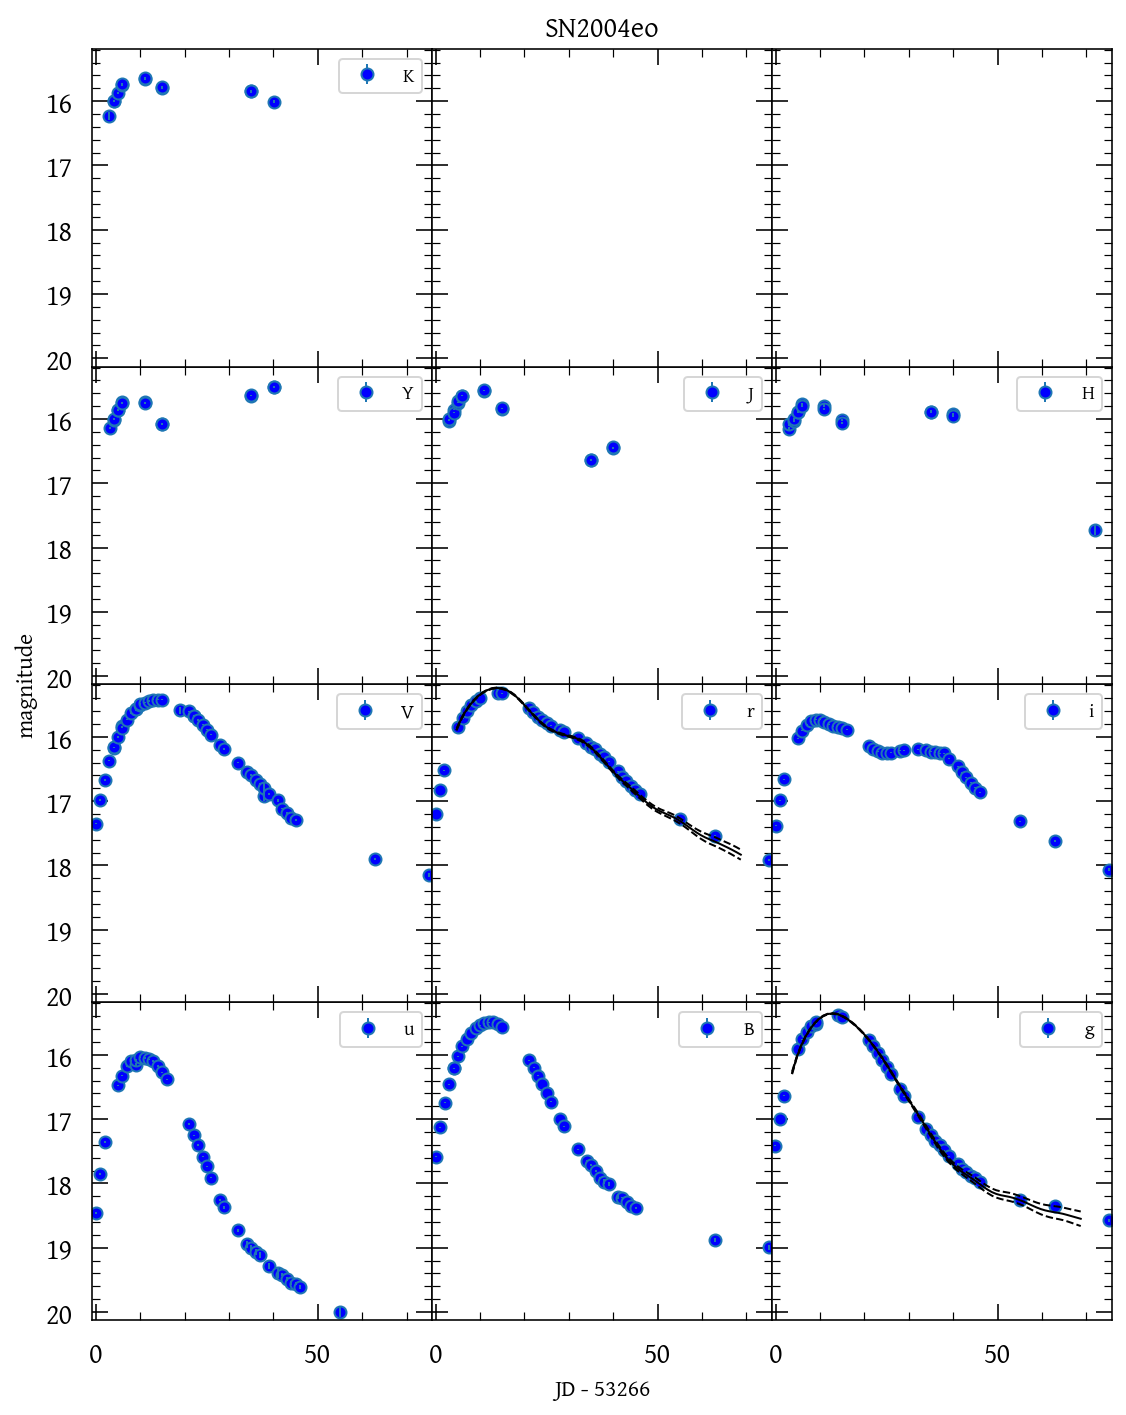

53278.74273856338


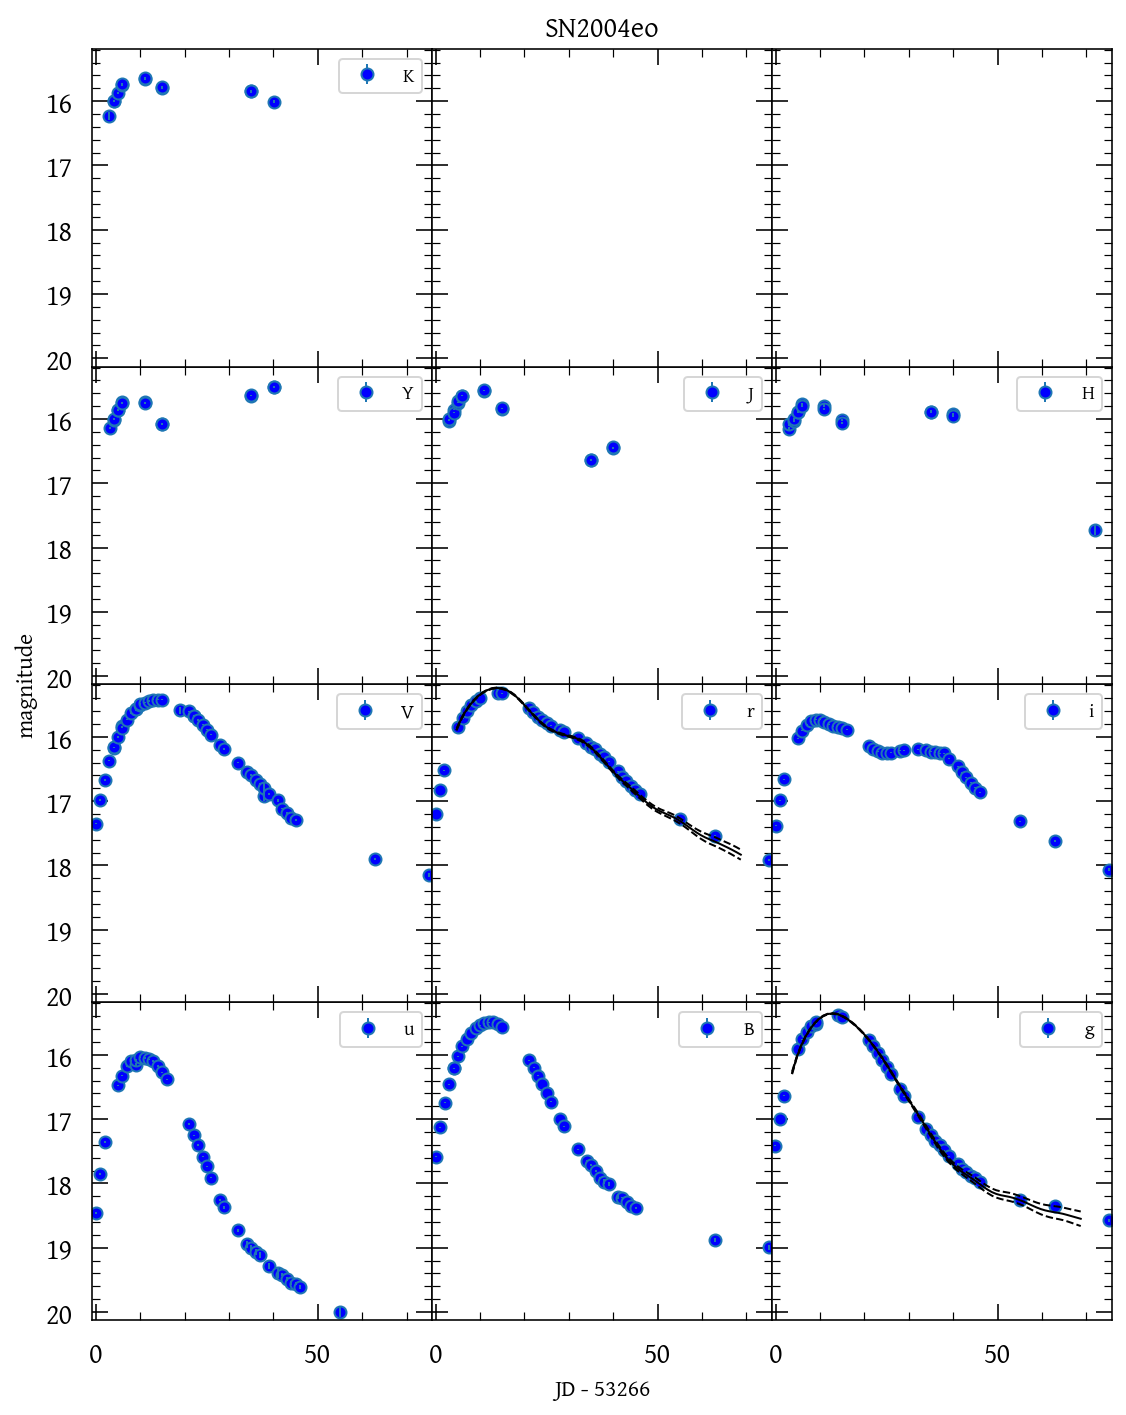

53278.74273856338


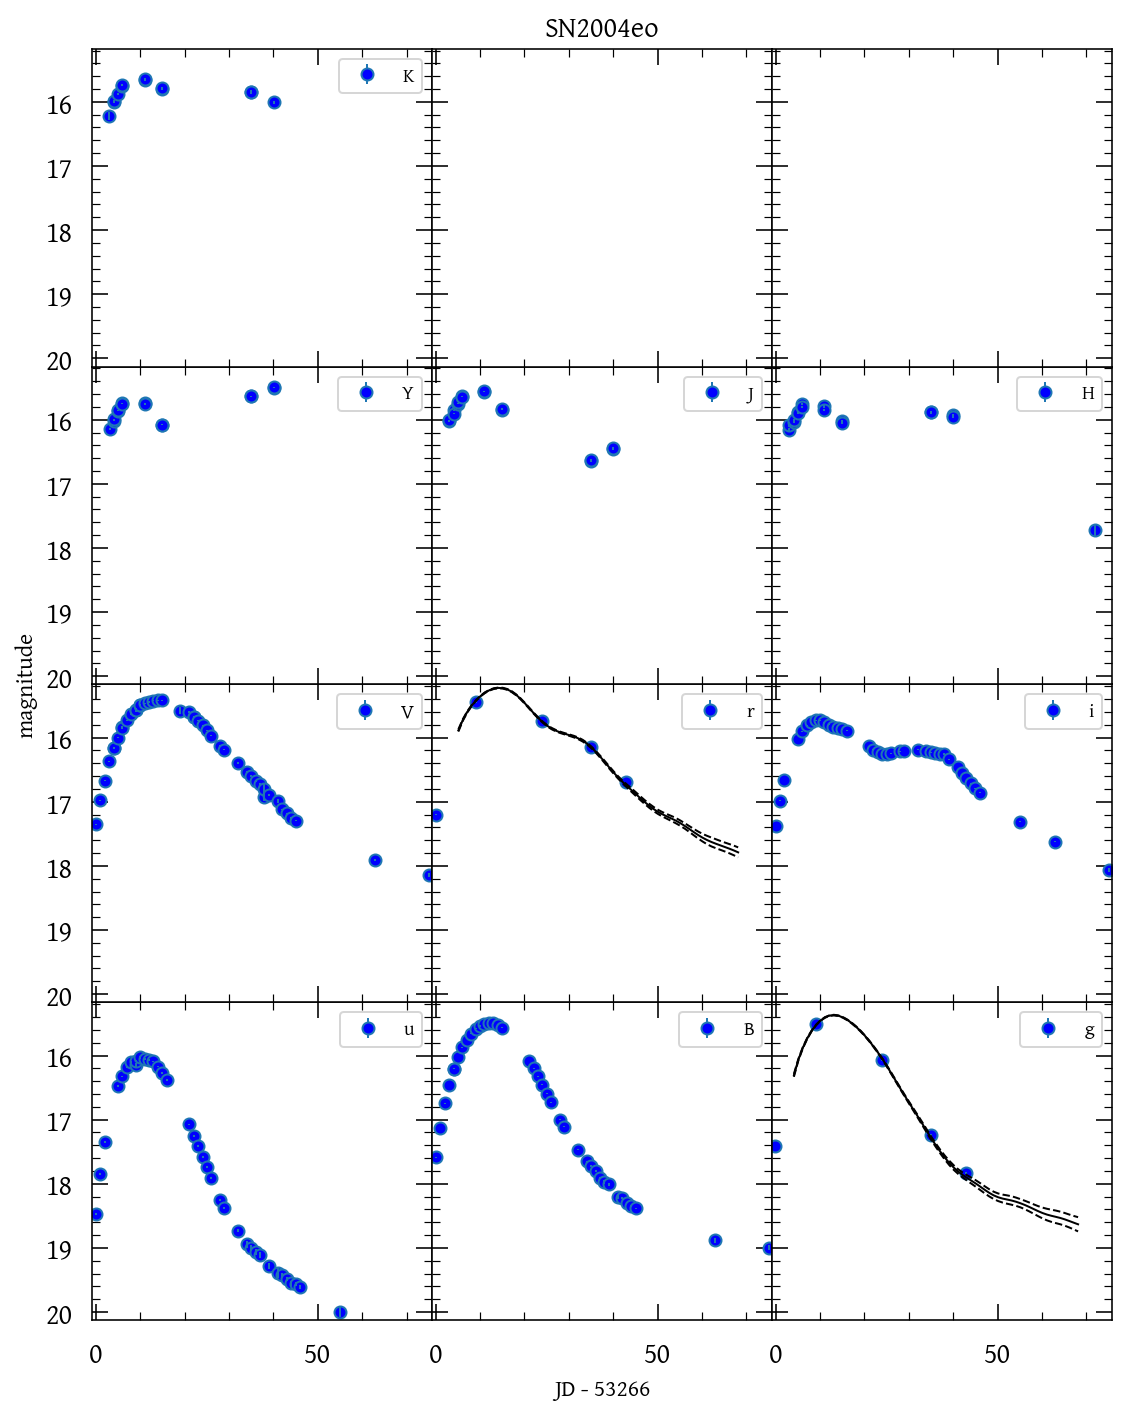

53279.14702684287


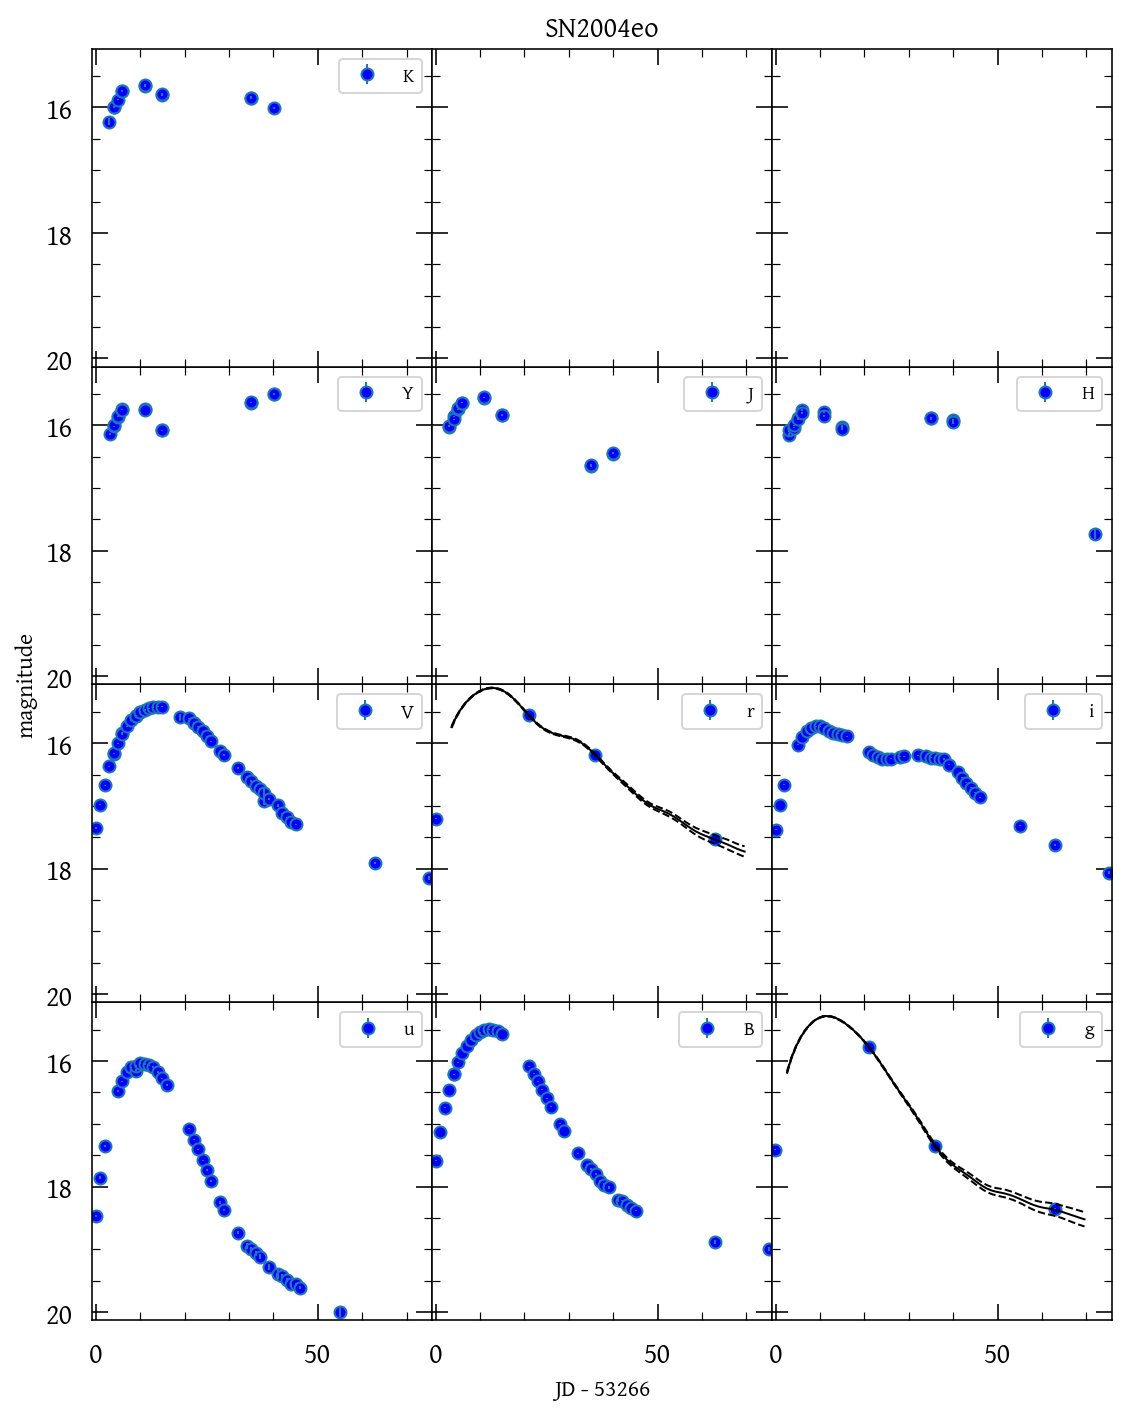

53277.59746311558


In [124]:
steps = [1, 7, 11]

sn = snpy.import_lc('csp_data/SN2004eo_snpy.txt')
sn.choose_model(SNOOPY_MODEL)
sn.fit(['g', 'r'])
sn.plot()
plt.show()
print(sn.Tmax)

cadences_list = []
cadences = {band:None for band in sn.allbands()}
for band in sn.allbands():
    lc_len = len(sn.data[band].mask)
    lc_times = sn.data[band].MJD
    cadences[band] = np.mean(np.diff(lc_times))

# fits for multiple cadences
bands = ['g', 'r']

for step in steps:
    cadences = {band:None for band in bands}
    sn = snpy.import_lc('csp_data/SN2004eo_snpy.txt')
    sn.choose_model(SNOOPY_MODEL)
    
    for band in bands:
        lc_len = len(sn.data[band].mask)
        mask = cadence_mask(step, lc_len)
        sn.data[band].__dict__['mask'] = mask
        sn.data[band].MJD = sn.data[band].MJD[mask]
        sn.data[band].mag = sn.data[band].mag[mask]
        sn.data[band].magnitude = sn.data[band].magnitude[mask]
        sn.data[band].e_mag = sn.data[band].e_mag[mask]

        sn.data[band].sids = sn.data[band].sids[mask]
        sn.data[band].__dict__['mask'] = [True]*len(sn.data[band].MJD)

    sn.fit(bands)
    sn.plot()
    plt.show()
    print(sn.Tmax)

## SNR

In [36]:
with open('reference_files.txt') as ref_file:
    sn_files = ref_file.read().splitlines()

snr_list = Pool(PROCESSES).map(pool_fit2, (sn_file for sn_file in sn_files))

/home/tomas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:201: RuntimeWarning: invalid value encountered in log10
/home/tomas/anaconda3/lib/python3.6/site-packages/snpy/sn.py:360: RuntimeWarning: invalid value encountered in log10
  temp1[i] = -2.5*log10(af) + self.data[band].filter.zp


In [37]:
snr_stats_df = pd.concat(snr_list, ignore_index=True)
snr_stats_df.to_csv('snr_stats.csv', index=False)

___

In [38]:
snr_stats_df = pd.read_csv('snr_stats.csv')
sn_names = snr_stats_df.name.unique()

res_dict = {'Tmax_diff':[], 'Tmax_err':[], 'g':[], 'r':[],
            'same_snr':[], 'diff_snr':[]}
lc_snake = {band:{'err':[], 'time':[]} for band in ['J', 'H']}
for sn_name in sn_names:
    sn_df = snr_stats_df[snr_stats_df.name==sn_name]
    ref_df = sn_df.iloc[0]
    
    # using S/N in g-band as reference
    for i in range(1, len(sn_df)):
        sim_df = sn_df.iloc[i]
        if (sim_df.g>=0) and (sim_df.g<=300):
            Tmax_diff = sim_df.Tmax - ref_df.Tmax
            res_dict['Tmax_diff'].append(Tmax_diff)
            res_dict['Tmax_err'].append(sim_df.Tmax_err)
            res_dict['g'].append(sim_df.g)
            res_dict['r'].append(sim_df.r)
            if i==1:
                res_dict['same_snr'].append(True)
                res_dict['diff_snr'].append(False)
            else:
                res_dict['same_snr'].append(False)
                res_dict['diff_snr'].append(True)
            
            lc_dict = extract_gradient(ref_df.st)
            for band in ['J', 'H']:
                lc = lc_dict[band]
                time = lc['time'][:-1]+0.5
                grad = lc['slope']
                err = Tmax_diff * grad
                lc_snake[band]['err'].append(err)
                lc_snake[band]['time'].append(time)
            
res_df = pd.DataFrame(res_dict)

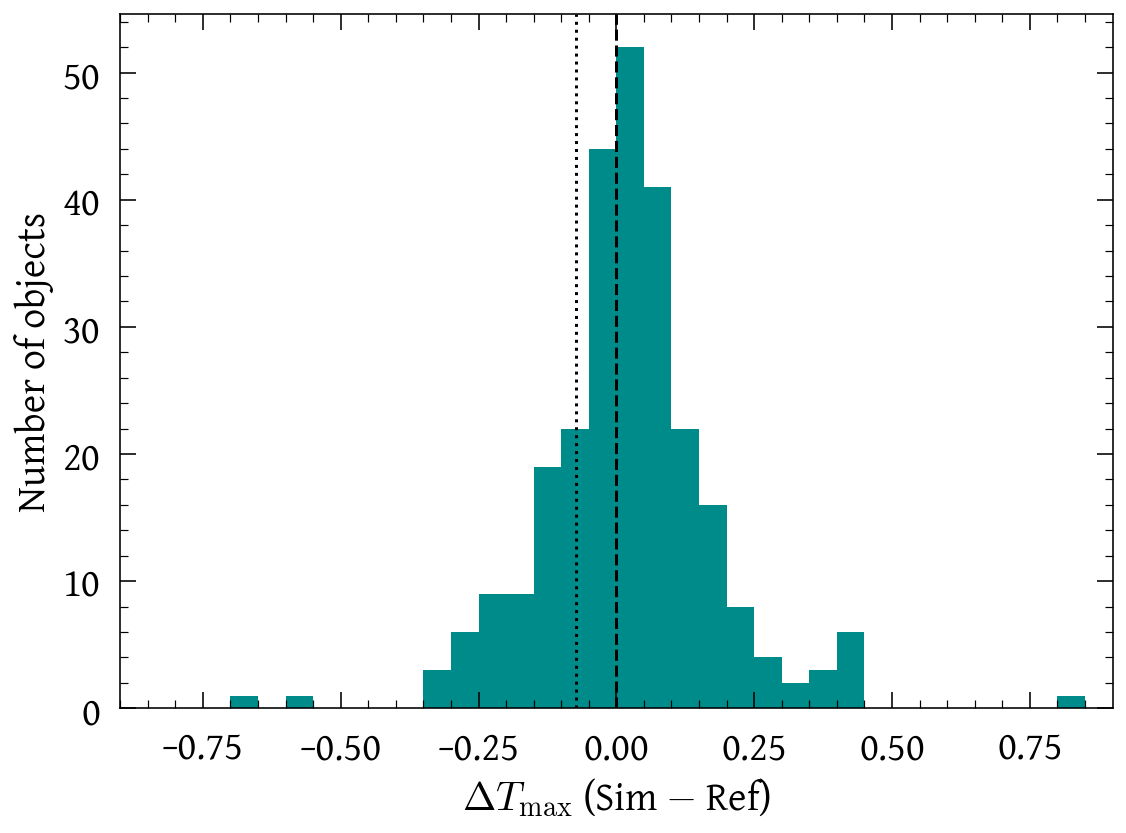

-0.0728778132079275


In [53]:
fig, ax = plt.subplots(figsize=(8, 6))

bins = np.arange(-1.0, 1.05, 0.05)
ax.hist(res_df.Tmax_diff, bins, color='darkcyan')
ax.axvline(0, ls='--', c='k')
ax.axvline(res_df.Tmax_diff.mean(), ls='dotted', c='k')

ax.set_xlabel(r'$\Delta T_{\rm max}$ (Sim $-$ Ref)', fontsize=20)
ax.set_ylabel('Number of objects', fontsize=20)
ax.tick_params(labelsize=20)
ax.set_xlim(-0.9, 0.9)

fig.tight_layout()
plt.savefig('paper_plots/delta_Tmax_snr.pdf')
plt.show()

print(res_df.Tmax_diff.mean())

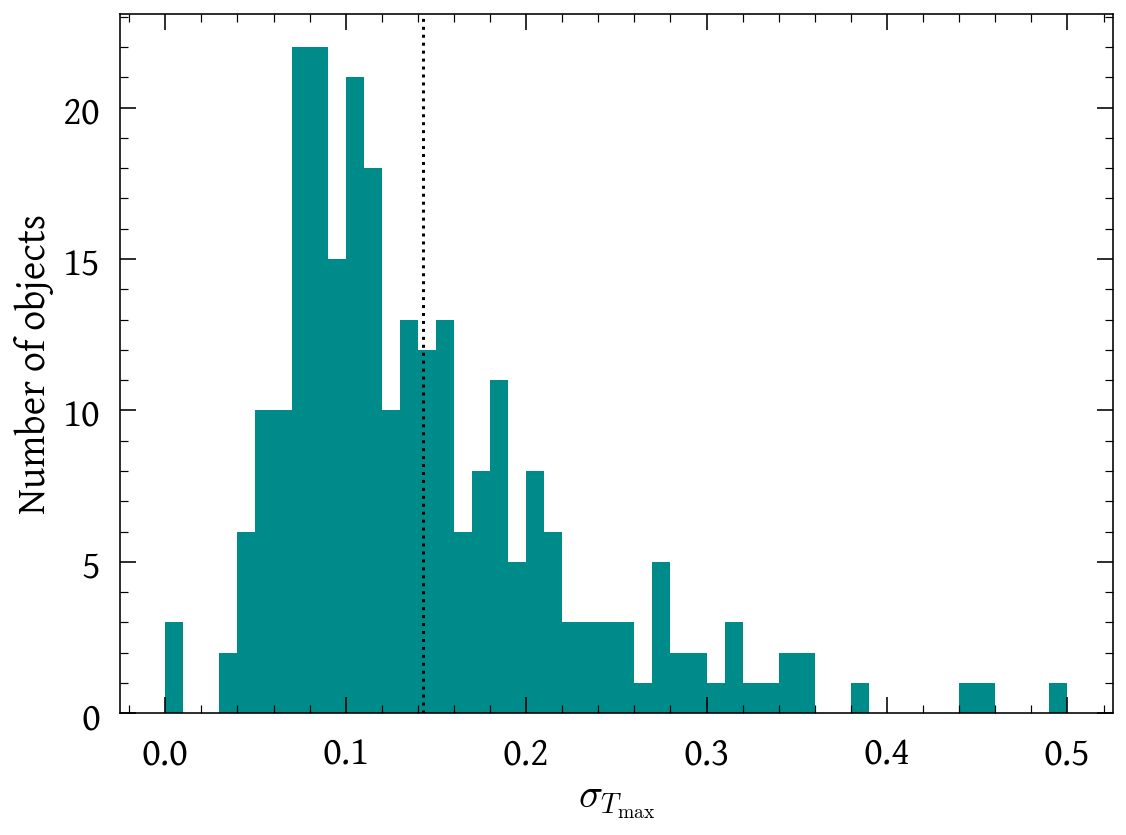

0.1425813585198627


In [45]:
# remove large uncertainty that can shift the mean
df = res_df[res_df.Tmax_err < 0.5]  

fig, ax = plt.subplots(figsize=(8, 6))

bins = np.arange(0, 0.51, 0.01)
ax.hist(df.Tmax_err, bins, color='darkcyan')
ax.axvline(df.Tmax_err.mean(), ls='dotted', c='k')

ax.set_xlabel(r'$\sigma_{T_{\rm max}}$', fontsize=20)
ax.set_ylabel('Number of objects', fontsize=20)
ax.tick_params(labelsize=20)
#ax.set_xlim(0, 0.55)

fig.tight_layout()
plt.savefig('paper_plots/sigma_Tmax_snr.pdf')
plt.show()

print(df.Tmax_err.mean())

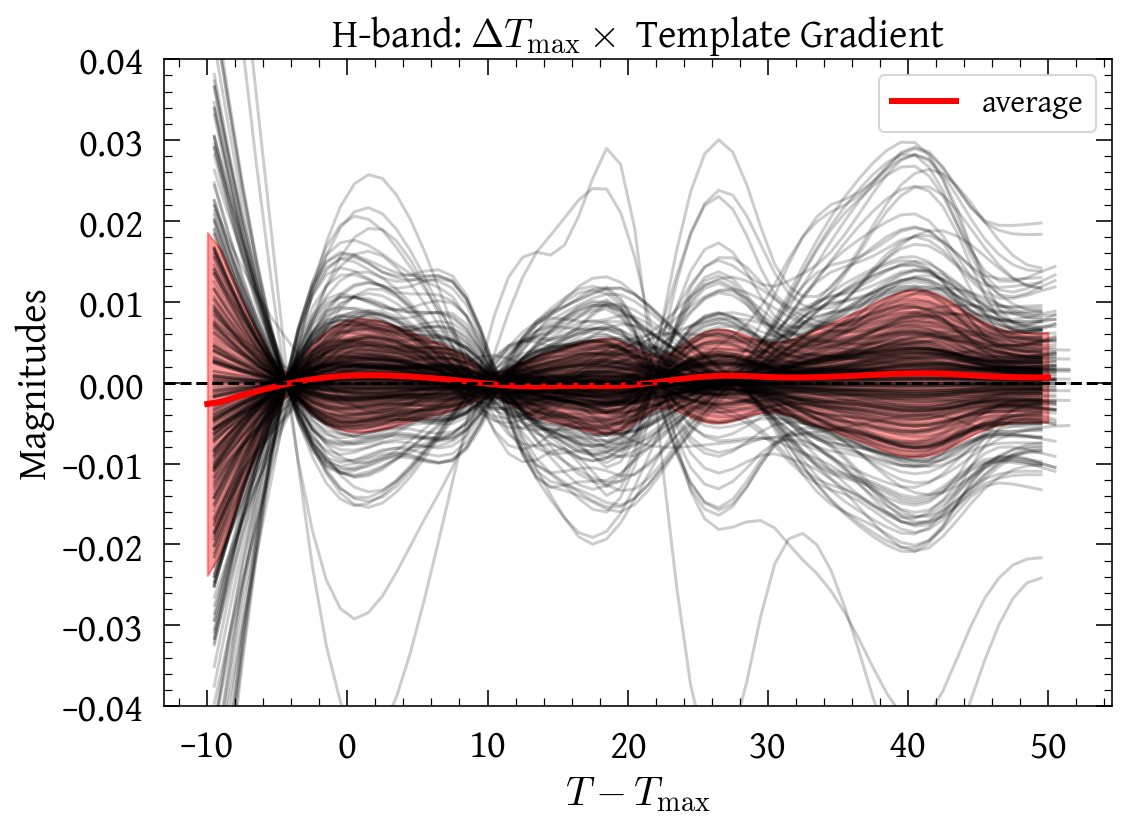

In [67]:
band = 'H'

avg_err = []
epochs = np.arange(-10, 51)

fig, ax = plt.subplots(figsize=(8, 6))
for err, time in zip(lc_snake[band]['err'], 
                     lc_snake[band]['time']):
    
    interp_err = np.interp(epochs, time, err)
    
    # remove weird outliers
    if np.all(np.abs(interp_err)<0.1):
        ax.plot(time, err, 'k', alpha=0.2)
        avg_err.append(interp_err)
    
std_err = np.std(avg_err, axis=0)
avg_err = np.average(avg_err, axis=0)
ax.plot(epochs, avg_err, 'r', label='average', lw=3)
ax.fill_between(epochs, avg_err+std_err, avg_err-std_err, color='r', alpha=0.4)
ax.axhline(0, ls='--', c='k')

ax.set_xlabel(r'$T - T_{\rm max}$', fontsize=20)
ax.set_ylabel('Magnitudes', fontsize=20)
ax.set_title(f'{band}-band: '+r'$\Delta T_{\rm max} \times$ Template Gradient', fontsize=20)
ax.tick_params(labelsize=20)
ax.set_ylim(-0.04, 0.04)
ax.legend(loc=1, fontsize=16)
fig.tight_layout()
plt.savefig(f'paper_plots/Tmax_gradient_snr_{band}.pdf')
plt.show()

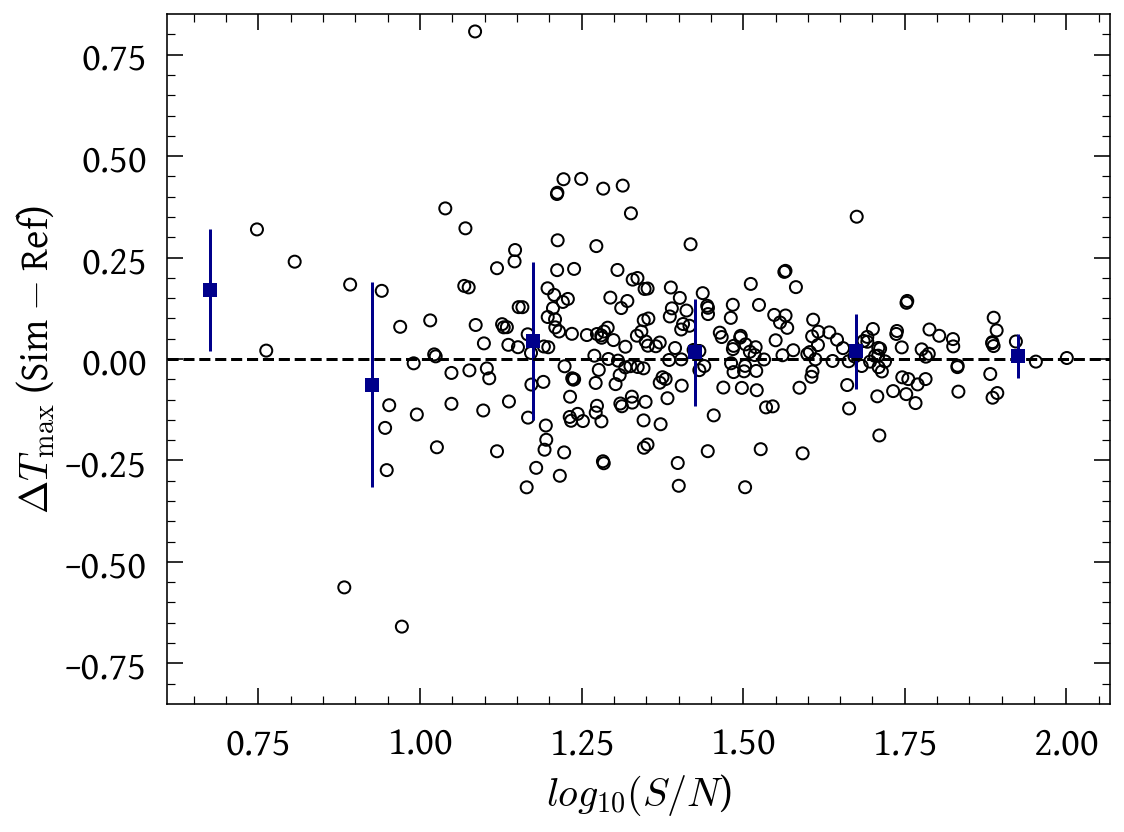

In [65]:
df = res_df[np.abs(res_df.Tmax_diff)<0.85]  # weird outliers

step = 0.25
bins = np.arange(0.8, 2.0+step, step)
bins_results =  bin_values(bins, np.log10(df.g.values), 
                           df.Tmax_diff.values, 
                           np.ones_like(df.g.values))
delta_bins, std_bins, err_bins = bins_results


fig, ax = plt.subplots(figsize=(8, 6))

ax.scatter(np.log10(df.g), df.Tmax_diff, marker='o' , ec='k', facecolors='none')
same_snr_df = res_df[res_df.same_snr.values]

# same S/N
#ax.scatter(np.log10(same_snr_df.g), same_snr_df.Tmax_diff, marker='o', c='m', alpha=0.4)

# bins
ax.errorbar(bins-step/2, delta_bins, yerr=std_bins, fmt='s', c='darkblue')

ax.axhline(0, ls='--', c='k')

ax.set_xlabel(r'$log_{10}(S/N$)', fontsize=20)
ax.set_ylabel(r'$\Delta T_{\rm max}$ (Sim $-$ Ref)', fontsize=20)
ax.tick_params(labelsize=20)
ax.set_ylim(-0.85, 0.85)

fig.tight_layout()
plt.savefig(f'paper_plots/delta_Tmax_vs_snr.pdf')
plt.show()

___

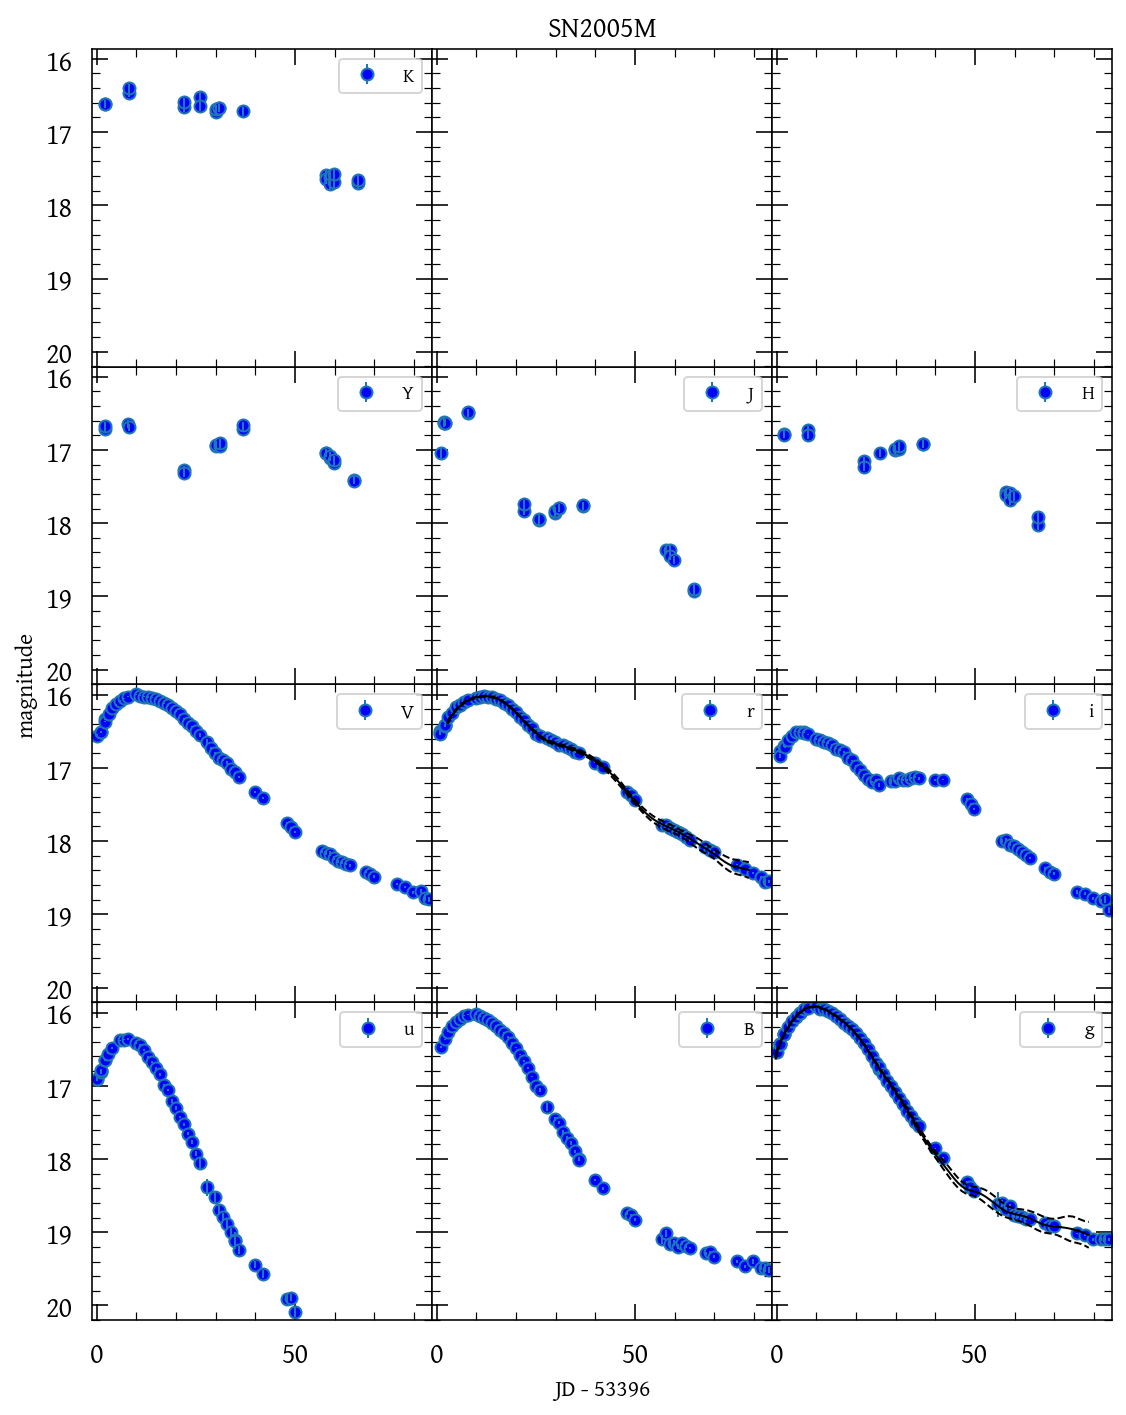

53405.98139856311


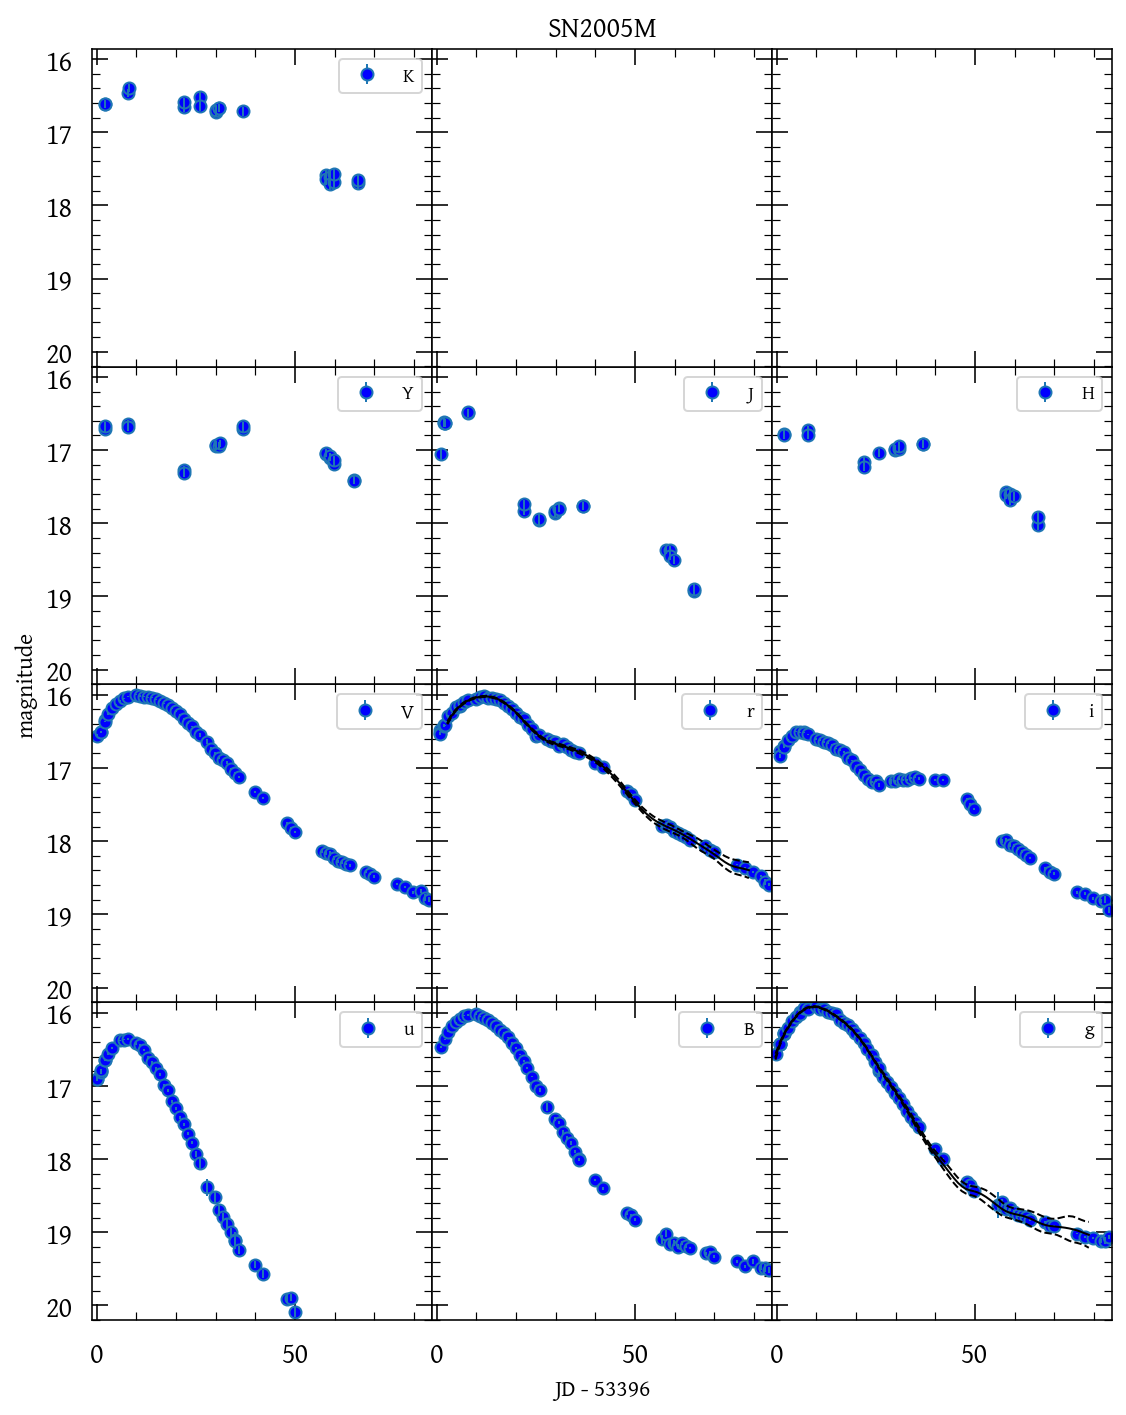

53405.991978438775


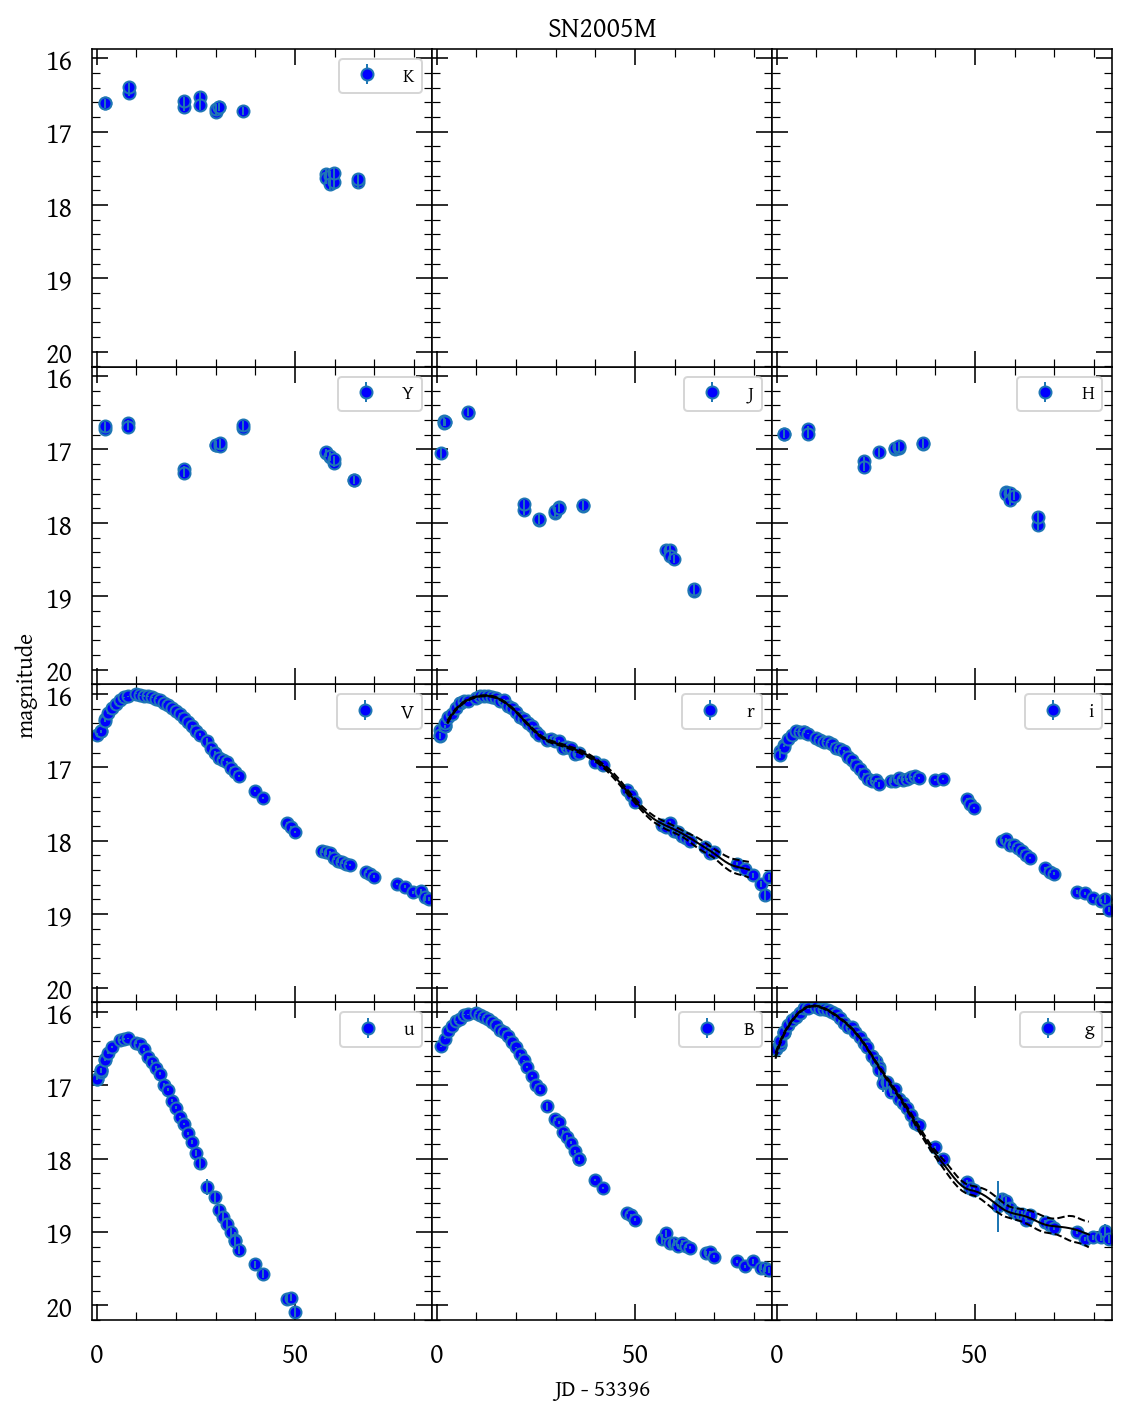

53405.987653208176


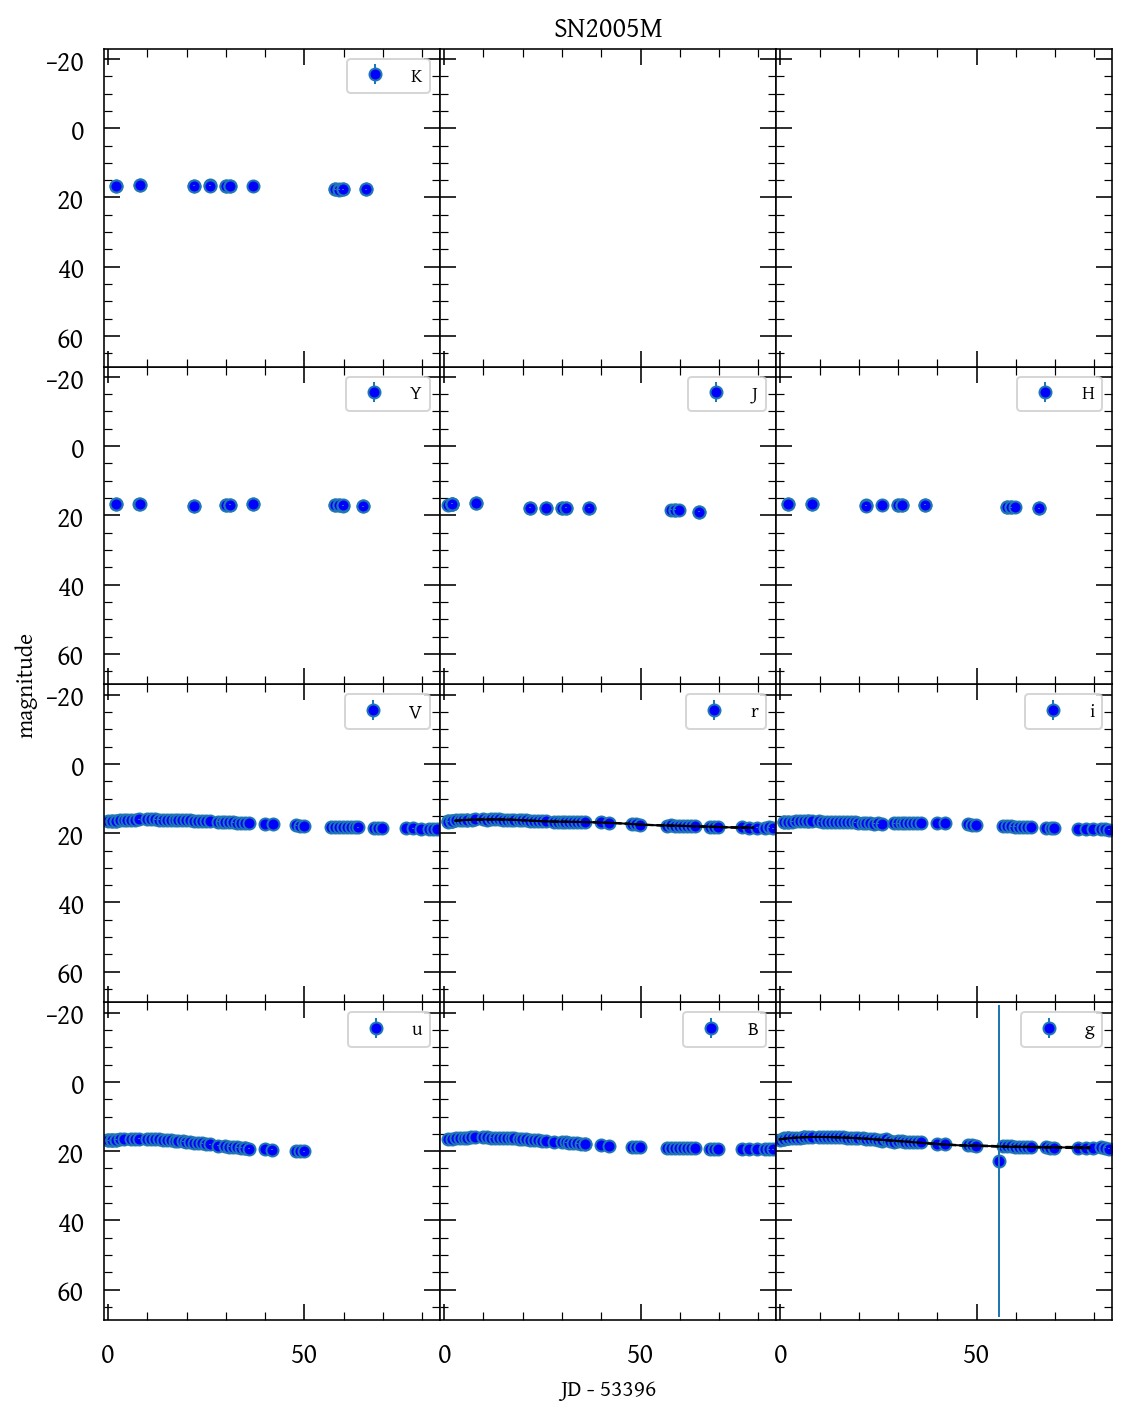

53406.07692386081


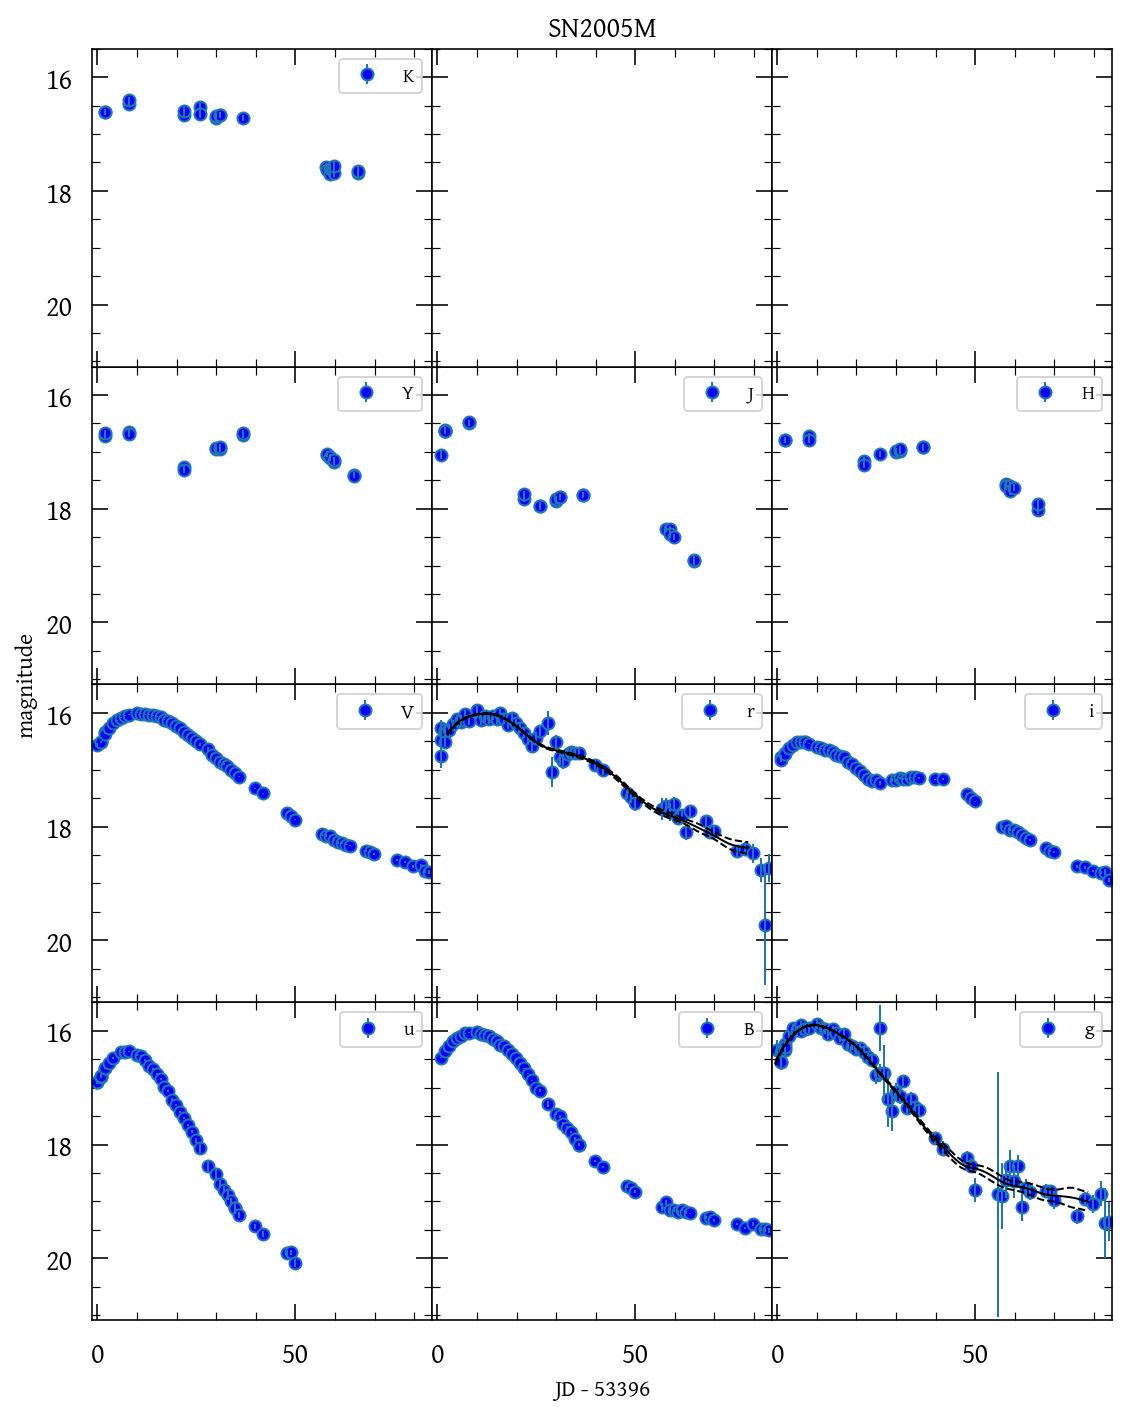

53405.82830839992


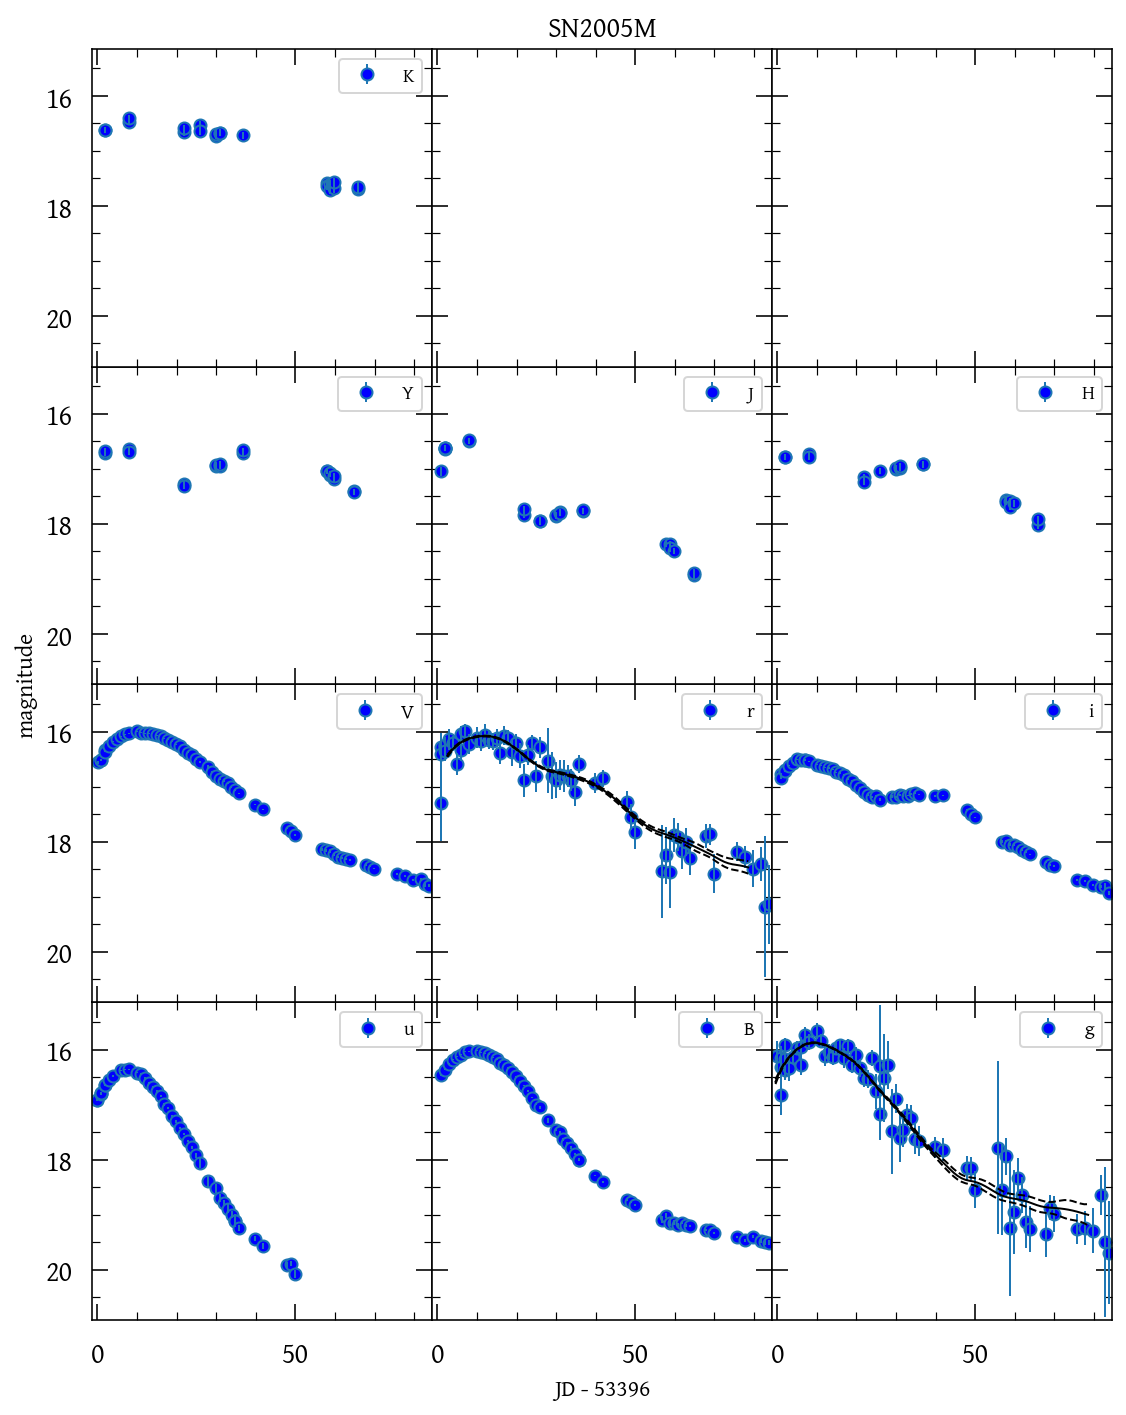

53405.81525944654


In [123]:
steps = [1, 2, 5, 10, 20]

sn = snpy.import_lc('csp_data/SN2005M_snpy.txt')
sn.choose_model(SNOOPY_MODEL)
sn.fit(['g', 'r'])
sn.plot()
plt.show()
print(sn.Tmax)

cadences_list = []
cadences = {band:None for band in sn.allbands()}
for band in sn.allbands():
    lc_len = len(sn.data[band].mask)
    lc_times = sn.data[band].MJD
    cadences[band] = np.mean(np.diff(lc_times))

# fits for multiple cadences
bands = ['g', 'r']

for step in steps:
    sn = snpy.import_lc('csp_data/SN2005M_snpy.txt')
    sn.choose_model(SNOOPY_MODEL)
    
    for band in bands:
        # unchanged observations
#         sn.data[band].e_flux = step*sn.data[band].e_flux
#         sn.data[band]._eflux = step*sn.data[band]._eflux
#         sn.data[band].e_mag = step*sn.data[band].e_mag
        
        # randomise observations within uncertinties
        sn.data[band].e_flux = step*sn.data[band].e_flux
        sn.data[band]._eflux = step*sn.data[band]._eflux

        zp = sn.data[band].mag + 2.5*np.log10(sn.data[band].flux)
        new_flux = np.random.normal(sn.data[band].flux, sn.data[band].e_flux)
        sn.data[band].flux = new_flux

        new_mag = -2.5*np.log10(new_flux) + zp
        new_mag_err = np.abs( 2.5*sn.data[band].e_flux/(new_flux*np.log(10)) )
        sn.data[band].mag = new_mag
        sn.data[band].magnitude = new_mag
        sn.data[band].e_mag = new_mag_err

    sn.fit(bands)
    sn.plot()
    plt.show()
    print(sn.Tmax)

In [165]:
sn.summary()

--------------------------------------------------------------------------------
SN  SN2004eo
z = 0.0157          zcmb = 0.0147          ra=308.22580         dec=  9.92850 
Data in the following bands: g,  r,  i,  u,  B,  V,  J,  H,  K,  Y,  
Fit results (if any):
   st = 0.823  +/-  0.007  +/- 0.030 (sys)
   Tmax = 53278.770  +/-  0.071  +/- 0.340 (sys)
   gmax = 15.042  +/-  0.012  +/- 0.014 (sys)
   rmax = 15.017  +/-  0.008  +/- 0.022 (sys)
